## 06 - Spatial Regridding and masking data cubes 
### A DeepESDL example notebook 

This notebook demonstrates how to access two different data sets, transform one of them so that both share the same spatial grid, and mask one dataset by applying a condition from the other dataset. 


Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/user-guide/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2023

-----------------

**This notebook runs with the python environment `deepesdl-cube-gen-xcube-1.0.1`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [1]:
# mandatory imports
import xarray as xr
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space
from xcube.core.store import new_data_store
from xcube.core.maskset import MaskSet
import shapely.geometry
from IPython.display import JSON
import datetime
import numpy as np
import pandas as pd

Open CCI store 

In [2]:
cci_store = new_data_store('cciodp')

Open s3 store and list all datasets 

In [3]:
root = "deep-esdl-public"

In [4]:
s3_store = new_data_store("s3", root=root)

In [5]:
list(s3_store.get_data_ids())

['LC-1x2160x2160-1.0.0.levels',
 'LC-1x2160x2160-1.0.0.zarr',
 'SMOS-snow-1x720x720-1.0.1.zarr',
 'SMOS-snow-4267x10x10-1.0.1.zarr',
 'black-sea-1x1024x1024.levels',
 'black-sea-1x1024x1024.zarr',
 'black-sea-256x128x128.zarr',
 'esdc-8d-0.25deg-1x720x1440-3.0.1.zarr',
 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr',
 'ocean-1M-9km-1x1080x1080-1.4.0.levels',
 'ocean-1M-9km-1x1080x1080-1.4.0.zarr',
 'ocean-1M-9km-64x256x256-1.4.0.zarr']

Open Land Cover (LC) dataset from s3 bucket:

In [6]:
LC = s3_store.open_data('LC-1x2160x2160-1.0.0.zarr', decode_cf = True)

In [7]:
LC

<xarray.Dataset>
Dimensions:              (time: 11, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 2010-01-01 ... 2020-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    crs                  (time) int32 dask.array<chunksize=(11,), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    lat_bounds           (time, lat, bounds) float64 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    lon_bounds           (time, lon, bounds) float64 dask.array<chunksize=(1, 2160, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095431Z
    ...                         ...
    time_coverage_end:          20101231
    time_coverage_resolution:   P1Y
    time_coverage_start:        20100101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                96ac9aca-1ca7-45c6-b4a5-ab448c692646
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

Now let's search for snow datasets provided via the xcube cci store: 

In [8]:
iterator = cci_store.search_data(cci_attrs=dict(ecv='SNOW'))
JSON([item.to_dict() for item in iterator])

<IPython.core.display.JSON object>

Open Snow Cover (SC) dataset from xcube cci store:

In [12]:
SC = cci_store.open_data('esacci.SNOW.day.L3C.SCFG.MODIS.Terra.MODIS_TERRA.2-0.r1')
SC

/home/conda/deepesdl/7869f6417feaaddcb785dc67e0288e31944ddada231af4def64634287d9ae96b-20230321-140806-305549-69-cube-gen-xcube-1.0.1/lib/python3.9/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'scfg' has multiple fill values {-1, 255}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/conda/deepesdl/7869f6417feaaddcb785dc67e0288e31944ddada231af4def64634287d9ae96b-20230321-140806-305549-69-cube-gen-xcube-1.0.1/lib/python3.9/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'scfg_unc' has multiple fill values {-1, 255}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:      (lat: 18000, nv: 2, lon: 36000, time: 7617, bnds: 2)
Coordinates:
  * lat          (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.98 89.98 90.0
    lat_bnds     (lat, nv) float64 dask.array<chunksize=(18000, 2), meta=np.ndarray>
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lon_bnds     (lon, nv) float64 dask.array<chunksize=(36000, 2), meta=np.ndarray>
  * time         (time) datetime64[ns] 2000-02-24T12:00:00 ... 2020-12-31T12:...
    time_bnds    (time, bnds) datetime64[ns] dask.array<chunksize=(7617, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    scfg         (time, lat, lon) float32 dask.array<chunksize=(1, 1385, 2770), meta=np.ndarray>
    scfg_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 1385, 2770), meta=np.ndarray>
    spatial_ref  float64 ...
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.SNOW.day.L3C.SCFG.MODIS.Terra.MODIS_TERRA...
    date_created:            2023-04-13T14:17:51.685800
    processing_level:        L3C
    time_coverage_start:     2000-02-24T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7617DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

**Subsetting time and space for the sake of an efficient example**

Temporal subset, entire 2015:

In [13]:
start_date = datetime.datetime(2015,1,1)
stop_date = datetime.datetime(2015,12,31)

Spatial subset:

In [14]:
min_lat = 70.
max_lat = 60.
min_lon = 15
max_lon = 25.

Subsetting the Land Cover dataset, results in only one time slice per year for LC: 

In [15]:
LC = LC.sel(lat=slice(min_lat, max_lat), 
            lon=slice(min_lon, max_lon), 
            time=slice(start_date, stop_date))

In [16]:
LC

<xarray.Dataset>
Dimensions:              (time: 1, lat: 3600, lon: 3600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 70.0 70.0 69.99 69.99 ... 60.01 60.0 60.0
  * lon                  (lon) float64 15.0 15.0 15.01 15.01 ... 24.99 25.0 25.0
  * time                 (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    crs                  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    lat_bounds           (time, lat, bounds) float64 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    lon_bounds           (time, lon, bounds) float64 dask.array<chunksize=(1, 1080, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095431Z
    ...                         ...
    time_coverage_end:          20101231
    time_coverage_resolution:   P1Y
    time_coverage_start:        20100101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                96ac9aca-1ca7-45c6-b4a5-ab448c692646
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

Subsetting the Snow Cover dataset, choosing only one month here to reduce data transfer from CCI ODP:

In [17]:
start_date = datetime.datetime(2015,4,1)
stop_date = datetime.datetime(2015,4,30)

In [18]:
SC = SC.sel(lat=slice(max_lat, min_lat), 
            lon=slice(min_lon, max_lon), 
            time=slice(start_date, stop_date))

In [19]:
SC

<xarray.Dataset>
Dimensions:      (lat: 1000, nv: 2, lon: 1000, time: 29, bnds: 2)
Coordinates:
  * lat          (lat) float64 60.0 60.01 60.02 60.03 ... 69.97 69.98 69.98 70.0
    lat_bnds     (lat, nv) float64 dask.array<chunksize=(1000, 2), meta=np.ndarray>
  * lon          (lon) float64 15.01 15.01 15.03 15.04 ... 24.97 24.99 25.0
    lon_bnds     (lon, nv) float64 dask.array<chunksize=(1000, 2), meta=np.ndarray>
  * time         (time) datetime64[ns] 2015-04-01T12:00:00 ... 2015-04-29T12:...
    time_bnds    (time, bnds) datetime64[ns] dask.array<chunksize=(29, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    scfg         (time, lat, lon) float32 dask.array<chunksize=(1, 235, 1000), meta=np.ndarray>
    scfg_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 235, 1000), meta=np.ndarray>
    spatial_ref  float64 ...
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.SNOW.day.L3C.SCFG.MODIS.Terra.MODIS_TERRA...
    date_created:            2023-04-13T14:17:51.685800
    processing_level:        L3C
    time_coverage_start:     2000-02-24T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7617DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

**Resample to the same Grid**

Here we use xcube's GridMapping method to extract the specification of both grids. Snow Cover is the grid to be transformed.

In [20]:
source_gm = GridMapping.from_dataset(SC)

In [21]:
source_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: True
* is_lon_360: False
* crs: GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]
* xy_res: (0.01, 0.01)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 1000, 1000)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (1000, 1000)
* tile_size: (1000, 765)

The target grid mapping is the one from the Land Cover dataset:

In [22]:
target_gm = GridMapping.from_dataset(LC)

In [23]:
target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.002777775, 0.002777775)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 3600, 3600)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (3600, 3600)
* tile_size: (2160, 2160)

Now we resample Snow Cover to the grid provided by Land Cover:

In [24]:
resampled_SC = resample_in_space(SC, 
                                 source_gm=source_gm, 
                                 target_gm=target_gm)

Lets compare the different grid mappings, to see whether the resampeled Snow Cover datasets has the desired grid mapping now: 

Our source gridmapping, the original Snow Cover grid mapping:

In [25]:
source_gm.crs 

<Geographic 2D CRS: GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WG ...>
Name: \"WGS 84\"
Axis Info [ellipsoidal]:
- [north]: \"Latitude\" (\"degree\")
- [east]: \"Longitude\" (\"degree\")
Area of Use:
- undefined
Datum: \"WGS_1984\"
- Ellipsoid: \"WGS 84\"
- Prime Meridian: \"Greenwich\"

The grid mapping of Land Cover which was the target grid mapping:

In [26]:
target_gm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The grid mapping of our resampeled Snow Cover, which is as expeced the same as the target grid mapping.

In [27]:
GridMapping.from_dataset(resampled_SC).crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Create a mask from LC classes**

Now that we have our two datasets with the same gridmapping we can use the land cover classes to mask the Snow Cover datasets.

Converting as they need to be an numpy array to be used with MaskSet:

In [28]:
LC.lccs_class.attrs['flag_values'] = np.array(LC.lccs_class.attrs['flag_values'])

Creating a Land Cover mask from the classes using xcube's MaskSet:

In [29]:
LC_mask = MaskSet(LC.lccs_class)

In [30]:
LC_mask

Flag name,Mask,Value
no_data,None,0
cropland_rainfed,None,10
cropland_rainfed_herbaceous_cover,None,11
cropland_rainfed_tree_or_shrub_cover,None,12
cropland_irrigated,None,20
mosaic_cropland,None,30
mosaic_natural_vegetation,None,40
tree_broadleaved_evergreen_closed_to_open,None,50
tree_broadleaved_deciduous_closed_to_open,None,60
tree_broadleaved_deciduous_closed,None,61


**For the masking to work, both data arrays must have identical coordinates, we thus enforce this condition by assigning coordinates and merging into one dataset**

For the masking example, one specific class, rainfed cropland, is choosen here: 

In [31]:
LC_cropmask = LC_mask.cropland_rainfed.to_dataset()

Although the coordiantes of the LC dataset and the resampled_SC dataset are almost identical, tiny numerical differences would prevent the masking from working. Thus, the coordinates from the resampled_SC dataset are assigned as the coordinates to the LC_cropmask

In [32]:
LC_cropmask = LC_cropmask.assign_coords(lat = resampled_SC.lat, 
                                        lon = resampled_SC.lon)

The resulting dataset is again a data cube with only one time slices

In [33]:
LC_cropmask

<xarray.Dataset>
Dimensions:           (lat: 3600, lon: 3600, time: 1)
Coordinates:
  * lat               (lat) float64 70.0 70.0 69.99 69.99 ... 60.01 60.0 60.0
  * lon               (lon) float64 15.0 15.0 15.01 15.01 ... 24.99 25.0 25.0
  * time              (time) datetime64[ns] 2015-01-01
Data variables:
    cropland_rainfed  (time, lat, lon) uint8 dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>

Because both dasets share the same spatial grid, we can now insert the cropland_rainfed mask as an additional data variable into the resampled_SC datacube. By selecting the only time slice, we remove the time information here. The new data variable crop_mask in the resulting dataset thus only depending on lat and lon. 

In [34]:
resampled_SC['crop_mask'] = LC_cropmask.cropland_rainfed.isel(time=0)

In [35]:
resampled_SC

<xarray.Dataset>
Dimensions:      (time: 29, lat: 3600, lon: 3600, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2015-04-01T12:00:00 ... 2015-04-29T12:...
    time_bnds    (time, bnds) datetime64[ns] dask.array<chunksize=(29, 2), meta=np.ndarray>
  * lon          (lon) float64 15.0 15.0 15.01 15.01 ... 24.99 24.99 25.0 25.0
  * lat          (lat) float64 70.0 70.0 69.99 69.99 ... 60.01 60.01 60.0 60.0
    lon_bnds     (lon, bnds) float64 15.0 15.0 15.0 15.01 ... 25.0 25.0 25.0
    lat_bnds     (lat, bnds) float64 70.0 70.0 70.0 69.99 ... 60.0 60.0 60.0
Dimensions without coordinates: bnds
Data variables:
    scfg         (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    scfg_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    spatial_ref  int64 0
    crop_mask    (lat, lon) uint8 dask.array<chunksize=(1440, 1080), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.SNOW.day.L3C.SCFG.MODIS.Terra.MODIS_TERRA...
    date_created:            2023-04-13T14:17:51.685800
    processing_level:        L3C
    time_coverage_start:     2000-02-24T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P7617DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Plot the mask of rainfed croplands (1 True, 0 False).

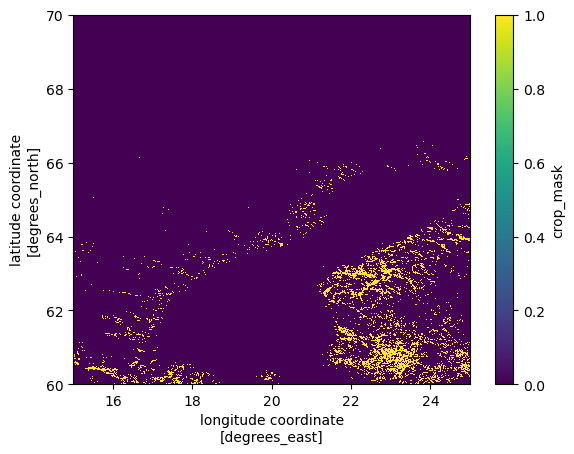

In [36]:
resampled_SC.crop_mask.plot()

**Mask one data array with a condition from another, inserted into one dataset**

Select Snow Cover (scfg) only for rainfed croplands. The result is again a datacube of the same dimensions as the inputs, because we removed the time information from the cropmask before. We only include data in the valid data range between 0 and 100. Values larger than 200 correspond to the flag values of the product. Note that the negative flag values specified in the datasets metadata are erroneusly provided by the data source. 

In [37]:
SC_crop = resampled_SC.scfg.where(resampled_SC.scfg <=100.).where(resampled_SC.crop_mask == 1)
SC_crop

<xarray.DataArray 'scfg' (time: 29, lat: 3600, lon: 3600)>
dask.array<where, shape=(29, 3600, 3600), dtype=float32, chunksize=(1, 1440, 1080), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-04-01T12:00:00 ... 2015-04-29T12:00:00
  * lon      (lon) float64 15.0 15.0 15.01 15.01 15.01 ... 24.99 24.99 25.0 25.0
  * lat      (lat) float64 70.0 70.0 69.99 69.99 69.99 ... 60.01 60.01 60.0 60.0
Attributes:
    standard_name:        surface_snow_area_fraction
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    valid_range:          [0, -2]
    actual_range:         [0, 100]
    flag_values:          [-51, -50, -46, -41, -4, -3, -2]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfg_unc
    grid_mapping:         spatial_ref
    orig_data_type:       uint8
    fill_value:           -1
    size:                 4935816000000
    shape:                [7617, 18000, 36000]
    chunk_sizes:          [1, 1385, 2770]
    file_chunk_sizes:     [1, 1385, 2770]
    data_type:            uint8
    dimensions:           ['time', 'lat', 'lon']
    file_dimensions:      ['time', 'lat', 'lon']

**Visualise result: scfg only on rainfed cropland**

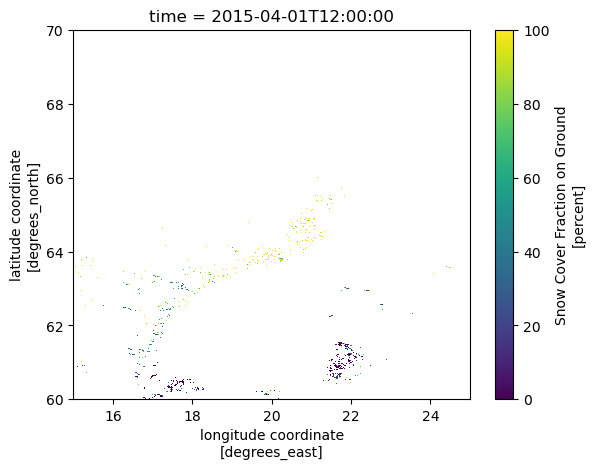

In [38]:
SC_crop.isel(time=0).plot()

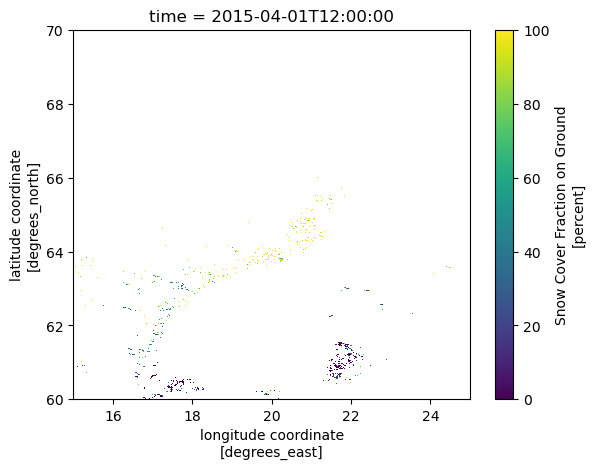

In [35]:
SC_crop.isel(time=0).plot()

The histogram of the scfg variable on rainfed croplands shows two dominating conditions: no snow or fully covered by snow.

(array([15452.,   549.,   430.,   411.,   358.,   399.,   427.,   435.,
          397.,   418.,   375.,   540.,   370.,   402.,   431.,   413.,
          403.,   368.,   371.,   353.,   364.,   336.,   471.,   328.,
          323.,   312.,   306.,   291.,   318.,   292.,   304.,   307.,
          280.,   357.,   386.,   270.,   284.,   287.,   299.,   261.,
          258.,   283.,   281.,   217.,   272.,   379.,   226.,   245.,
          261.,   286.,   236.,   225.,   218.,   289.,   268.,   248.,
          304.,   371.,   259.,   245.,   247.,   229.,   297.,   261.,
          251.,   288.,   257.,   273.,   450.,   323.,   284.,   336.,
          308.,   347.,   383.,   372.,   355.,   349.,   358.,   505.,
          389.,   441.,   417.,   459.,   413.,   465.,   495.,   486.,
          533.,   589.,   703.,   704.,   647.,   729.,   819.,   875.,
         1028.,  1063.,  1344., 11910.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12., 

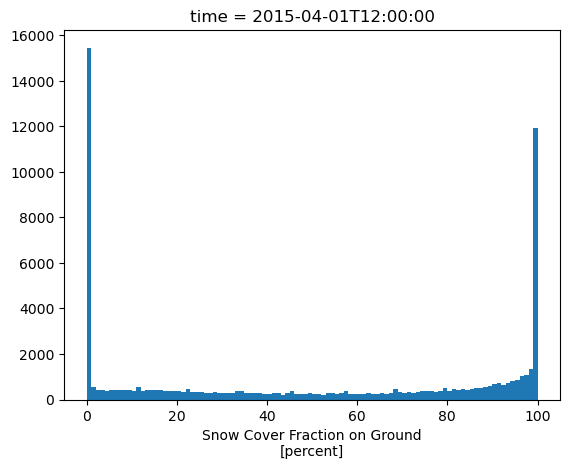

In [39]:
SC_crop.isel(time=0).plot.hist(bins=100)

For comparison, we also visualise the full snow cover product, without masking condition and with all flagged values, the ones >200.

flag_values : [205 206 210 215 252 253 254]

flag_meanings : Cloud Polar_Night_or_Night Water Permanent_Snow_and_Ice Classification_failed Input_Data_Error No_Satellite_Acquisition

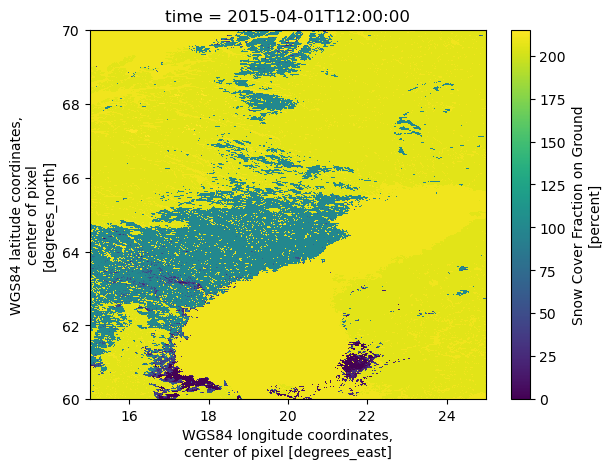

In [40]:
SC.scfg.isel(time=0).plot()